# GROUP MEMBERS

# Muhammad Usman             21-2312
# Shoaib Farooq                     21-2278
# Hizbullah Khan Jadoon      21-2310

# Import Libraries

In [1]:
# For handle with numpy arrays
import numpy as np
# For show image and plots
import matplotlib.pyplot as plt
# it provides a flexible N-dimensional array or Tensor
import torch
# which is used for data cleaning and analysis at datafram level.
import pandas as pd
# nn module to help us in creating and training of the neural network
from torch import nn
# used to return all file paths that match a specific pattern
import glob
#skimage images are stored as multi-dimensional NumPy arrays.
from skimage import io
# Transform object containing the transformation parameters and 
#providing access to forward and inverse transformation functions
from skimage import transform
# Combines a dataset and a sampler, and provides an iterable over the given dataset
from torch.utils.data import Dataset, DataLoader
# functional transforms give fine-grained control over the transformations.
from torchvision import transforms, utils
# # Ignore warnings
import warnings
warnings.filterwarnings("ignore")
##np.sqrt( np.sum( deepf - testf)**2 , axis = 1) )

# Data Loading Fropm PC

In [2]:
# Intilize datafram
frame = pd.DataFrame()

# Load LFW DataSet
abc = glob.glob('C:/Users/mshoa/Downloads/Compressed/lfw-deepfunneled/lfw-deepfunneled/*/*.jpg')

# Intilize two arrays
arr = []
arr2 = []
for i in abc:
    # Access and store name of each folder name related to person
    arr.append(i.replace('\\','/').split('/')[-2])
    # Access and store link of image exist in related folder
    arr2.append(i.replace('\\','/'))
# store person name and image link in Data Frame
frame['person'] = arr
frame['image'] = arr2

# Count() count image from each folder
# reset_Indec() Used to generate a new DataFrame or Series with the index reset
#make group on the basis of person and number of images
new = frame.groupby(['person'])['image'].count().reset_index()

#Select those persons from dataset which contain more than 4 images and store in a list
allowed_p = list(new.loc[new['image'] > 4]['person'])

# Maximum number of persons selected
n = 400

#Apply random sample using sample 
allowed_p = pd.Series(allowed_p).sample(n)

# intitlze a list for final selection
final_tuple_list = []
# selection for Anchor, Postive and Negative images
for i in allowed_p:
    for j in range(1):
        # Select anchore and positve images
        temp_p = list(frame.loc[frame['person']==i].sample(2)['image'])
        # Select Negative image
        temp_n = list(frame.loc[frame['person']!=i].sample(1)['image'])
        # Convort into touple like (AN, PO, NE)
        _tuple = (temp_p[0],temp_p[1],temp_n[0])
        # check condition for further selection
        if _tuple not in final_tuple_list:
            final_tuple_list.append(_tuple)

In [3]:
len(final_tuple_list)

400

# Dataset Class

In [4]:
class FaceDataset(Dataset):
    # Pass Data Tapule and Transform if need in constructor
    def __init__(self, data_tuple,  transform=None):
        # intilize for transformor
        self.transform = transform
        # intilization for touple
        self.data = data_tuple
    # function for data length
    def __len__(self):
        return len(self.data)
    
    #  It is magic method, which when used in a class, allows its instances to use the [] (indexer) operators
    def __getitem__(self, idx):
        # Pick value on the basis of index
        final_tuple = self.data[idx]
        # read Anchor image
        image0 = io.imread(final_tuple[0])[:,:,:3]
        # read Positve Image
        image1 = io.imread(final_tuple[1])[:,:,:3]
        # Read Negative image
        image2 = io.imread(final_tuple[2])[:,:,:3]
        # store into again in tauple for further uses
        final_tuple_image = (image0,image1,image2)
        
        # condition apply for transformation on images
        if self.transform:
            final_tuple_image = self.transform(final_tuple_image)
        # return images after processing
        return final_tuple_image

# Class for Rescalinging  of images

In [41]:
class Rescale(object):
    # intilization constructor passes outputsize passing during calling
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        # intilization for size for rescaling
        self.output_size = output_size

    # function for rescaling on three images
    def __call__(self, sample):
        # saparation three images 
        image0, image1, image2 = sample[0], sample[1], sample[2]
        
        # intilization height and width of the Anchore Image
        h, w = image0.shape[:2]
        
        # Condition on the basis of dimention on Anchore Image
        if False and  isinstance(self.output_size, int):
            # if height greater than width
            if h > w:
                # Apply rescaling Formula
                new_h, new_w = self.output_size * h / w, self.output_size
            # if height smaller than width
            else:
                # Apply rescaling Formula
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            # Apply rescaling Formula
            new_h, new_w = self.output_size, self.output_size
        # Update lengthe and width of image
        new_h, new_w = int(new_h), int(new_w)
        # Apply update on Anchor Image
        image0 = transform.resize(image0, (new_h, new_w))
        
        # intilization height and width of the Posative Image
        h, w = image1.shape[:2] 
        # Condition on the basis of dimention on Posative Image
        if False and isinstance(self.output_size, int):
            # if height greater than width
            if h > w:
                # Apply rescaling Formula
                new_h, new_w = self.output_size * h / w, self.output_size
            # if height smaller than width
            else:
                # Apply rescaling Formula
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            # Apply rescaling Formula
            new_h, new_w = self.output_size, self.output_size
        # Update lengthe and width of image
        new_h, new_w = int(new_h), int(new_w)
        # Apply update on Posative Image
        image1 = transform.resize(image1, (new_h, new_w))
        
        # intilization height and width of the Negative Image
        h, w = image2.shape[:2]
        # Condition on the basis of dimention on Negative Image
        if False and  isinstance(self.output_size, int):
            # if height greater than width
            if h > w:
                # Apply rescaling Formula
                new_h, new_w = self.output_size * h / w, self.output_size
            # if height smaller than width
            else:
                # Apply rescaling Formula
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            # Apply rescaling Formula
            new_h, new_w = self.output_size, self.output_size
        # Update lengthe and width of image
        new_h, new_w = int(new_h), int(new_w)
        # Apply update on Negative Image
        image2 = transform.resize(image2, (new_h, new_w))
        # Return Anchor, Positive, and, Negative images after the rescaling
        return (image0,image1,image2)

# Class for Random Crop on Images

In [42]:
class RandomCrop(object):
    # intilization constructor passes outputsize passing during calling
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            # intilization for size for rescaling
            self.output_size = (output_size, output_size)
        else:
            # Apply if primary condition fail
            assert len(output_size) == 2
            # intilization for size for rescaling
            self.output_size = output_size
    
    # function for rescaling on three images
    def __call__(self, sample):
        # saparation three images 
        image0, image1, image2 = sample[0][0], sample[0][1], sample[0][2]
        
        # intilization height and width of the Anchore Image
        h, w = image0.shape[:2]
        # Assign parameter according to given value
        new_h, new_w = self.output_size
        # apply calculation on top and left of image
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
         # Apply update on Anchor Image
        image0 = image0[top: top + new_h, left: left + new_w]
        
        # intilization height and width of the Posative Image
        h, w = image1.shape[:2]
        # Assign parameter according to given value
        new_h, new_w = self.output_size
        # apply calculation on top and left of image
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        # Apply update on Posative Image
        image1 = image1[top: top + new_h, left: left + new_w]
        
        # intilization height and width of the Negative Image
        h, w = image2.shape[:2]
        # Assign parameter according to given value
        new_h, new_w = self.output_size
        # apply calculation on top and left of image
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
         # Apply update on Negative Image
        image2 = image2[top: top + new_h, left: left + new_w]
        # Return Anchor, Positive, and, Negative images after the Croping
        return (image0,image1,image2)

# For tensor transformation on Images

In [43]:
class ToTensor(object):
    #Convert ndarrays in sample to Tensors
    def __call__(self, sample):
        # Apply or convort image vector into tansor formate for traninf and processing 
        image0, image1, image2 = sample[0], sample[1], sample[2]
        image0 = torch.from_numpy(image0.transpose((2, 0, 1)))
        image1 = torch.from_numpy(image1.transpose((2, 0, 1)))
        image2 = torch.from_numpy(image2.transpose((2, 0, 1)))
        return (image0,image1,image2)

### Calling

In [44]:
#Calling for transfomation, rescaling, from data set to data loder
transformed_dataset = FaceDataset(data_tuple = final_tuple_list, transform=transforms.Compose([
                                                                                               Rescale(128),
                                                                                               ToTensor()]))

# Data Loader

In [45]:
#Batch Size
batch_size = 1
# Create data loaders on the basis of batch.
train_dataloader = DataLoader(transformed_dataset, batch_size=batch_size)

# Select Device for Processing

In [46]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Define CNN For Training

In [47]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Intilize con1 layer 
        # 3 is depth of comming data
        # 100 is number of dilters
        # 3 size of each filter
        self.conv1 = nn.Conv2d(3,100,3)
        
        # Apply pooling layer 2 X 2
        # 2 Pooling window size
        # 2 is step size
        self.pool = nn.MaxPool2d(2, 2)
        
        # Intilize con2 layer 
        # 100 is depth of comming data
        # 50 is number of dilters
        # 5 size of each filter
        self.conv2 = nn.Conv2d(100, 50, 5)
        
        #Fully Connected Layer
        # Size of comming input  50 * 29 * 29
        # Number of neuron 50
        self.fc1 = nn.Linear(50 * 29 * 29, 50)
        
        #Fully Connected Layer
        # Size of comming input 50
        # Number of neuron 25
        self.fc2 = nn.Linear(50, 25)
    
    # Defin function for dorword Pass
    def forward(self, x):
        # Apply pooling on CON1
        #Apply on ReLu on pooled Data
        x = nn.functional.relu(self.pool(self.conv1(x)))
        
        # Apply pooling on CON2
        #Apply on ReLu on pooled Data
        x = nn.functional.relu(self.pool(self.conv2(x)))
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        
        # Apply ReLu o privious output after passing fully connected layer
        x = nn.functional.relu(self.fc1(x))
        
        # Passes final fully connected layer
        x = self.fc2(x)
        
        # retuen after traning
        return x

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=42050, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=25, bias=True)
)


# Apply Loss Function

In [48]:
# Apply triplet loss with margin value 10 and false average parameter
loss_fn = nn.TripletMarginLoss(margin=10, p=2,size_average=False)
# def loss_fn(feature):
#     lis = np.sqrt( np.sum( (np.array([feature[1].detach().numpy(),feature[2].detach().numpy()]) - np.array(feature[0].detach().numpy()))**2 , axis = 1))
#     print(lis)
#     return torch.from_numpy( np.array(10)) #lis[0]-lis[1]+10

# Optimizor

In [49]:
# For loss optimization using Adagrad which perform best than others
optimizer = torch.optim.Adagrad(model.parameters())

## Training & Drop Easy triplet

In [50]:
# Function for traning
# dataloader for data
# model for traning structure
# loss_fn for find loss during traning
# optimizer for optimization for loss
# off_triplet for drop easy triplets
def train(dataloader, model, loss_fn, optimizer,off_triplet):
    # get total data size
    size = len(dataloader.dataset)
    # for model traning
    model.train()
    # intilize loss is zero
    loss_t = 0
    # fatch anchore positive and nefative for traning
    for batch, (X, y , z) in enumerate(dataloader):
        # check for easy triplet
        if batch not in off_triplet:
            #to copy all the tensor variables at the beginning of reading data to the GPU specified by device
            X, y , z = X.to(device), y.to(device), z.to(device)
            # converstion
            y = y.float()
            # prediction for posative
            pred2 = model(y)
            # converstion
            z = z.float()
            # prediction for negative
            pred3 = model(z)
            # converstion
            X = X.float()
            # prediction for Anchor
            pred1 = model(X)
            # passes values for finding loss
            loss = loss_fn(pred1, pred2, pred3)
            
            # Sets the gradients of all optimized torch. Tensor s to zero. 
            optimizer.zero_grad()
            
            #for running backpropagation after measure loss
            loss.backward()
            
            # for optimization of loss
            optimizer.step()
            
            # calculated loss and current loss
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # total loss
            loss_t += loss
            # print('loss_print',loss,type(loss))
            
            #remove easy tiplets
            if loss < 0.01:
                print('removing ', batch)
                off_triplet.append(batch)
    # print total loss of each epoch
    print('loss of epoch ',loss_t)
    # return model offtriplets and total loss
    return model, off_triplet, loss_t

## Pickup Again Triplets

In [51]:
# dataloader for data
# model for traning structure
# loss_fn for find loss during traning
# optimizer for optimization for loss
# off_triplet for drop easy triplets
def PickUp(dataloader, model, loss_fn, optimizer,off_triplet):
    # get total data size
    size = len(dataloader.dataset)
    # for model traning
    model.train()
    # intilize loss is zero
    loss_t = 0
    print('enter in pickup')
    # fatch anchore positive and nefative for traning
    for batch, (X, y , z) in enumerate(dataloader):
        if batch in off_triplet:
            #to copy all the tensor variables at the beginning of reading data to the GPU specified by device
            X, y , z = X.to(device), y.to(device), z.to(device)
            # converstion
            y = y.float()
            pred2 = model(y)
            
            # converstion
            z = z.float()
            pred3 = model(z)
            
            # converstion
            X = X.float()
            pred1 = model(X)
            # passes values for finding loss
            loss = loss_fn(pred1, pred2, pred3 )

            # calculated loss and current loss
            loss, current = loss.item(), batch * len(X)
            # Loss or Triplets
            print('loss of off tripls ', loss)
            # Condition for repick triplets
            if loss > 0.1:
                # remove triplets from batch
                off_triplet.remove(batch)
                print(off_triplet.remove(batch))
    # return model offtriplets and total loss            
    return model, off_triplet, loss_t

# Running Epoch for Traning

In [52]:
# intilization og epoch
epochs = 14
# for store easy triplets
off_triplet=[]
# for running epoch
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # calling function for calling
    model, off_triplet, loss_t = train(train_dataloader, model, loss_fn, optimizer,off_triplet)
    # condition for repick triplets 
    if int(t+1) % 3 == 0:
        print('check the repick call ')
        mod, off_triplet, loss_t = PickUp(train_dataloader, model, loss_fn, optimizer,off_triplet)
    # shows easy triplets    
    print(off_triplet)
print("Done!")

Epoch 1
-------------------------------
removing  2
removing  5
removing  12
removing  16
removing  17
removing  21
removing  22
removing  35
removing  39
removing  41
removing  45
removing  59
removing  60
removing  84
removing  91
removing  117
removing  119
removing  122
removing  129
removing  134
removing  138
removing  155
removing  156
removing  158
removing  163
removing  171
removing  174
removing  177
removing  179
removing  180
removing  185
removing  192
removing  197
removing  206
removing  209
removing  211
removing  216
removing  217
removing  218
removing  219
removing  222
removing  224
removing  225
removing  228
removing  241
removing  244
removing  251
removing  258
removing  270
removing  275
removing  281
removing  286
removing  298
removing  304
removing  310
removing  316
removing  322
removing  327
removing  329
removing  330
removing  333
removing  334
removing  335
removing  337
removing  338
removing  341
removing  343
removing  344
removing  346
removing  3

# Testing

### Testing 1

In [54]:
# Images for testing
test_image= [('usman2.jpg','usman1.jpg','shoaib2.jpg')]

In [55]:
# preprocessing and sent to dataset
test_dataset = FaceDataset(data_tuple = test_image, 
                                           transform=transforms.Compose([
                                               Rescale(128),
                                               ToTensor()]))

In [56]:
# sent detals into data loader
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [57]:
# for testing
for batch, (x, y , z) in enumerate(test_dataloader):
        print(x.shape,y.shape,z.shape)
        x, y , z = x.to(device), y.to(device), z.to(device)
        x = x.float()
        usman1 = model(x)
        # Compute prediction error
        y = y.float()
        usman2 = model(y)
        z = z.float()
        shoaib2 = model(z)
        print('done')

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
done


In [58]:
# dict contanin testing on it
dict_ = np.array([usman2.detach().numpy()[0] , shoaib2.detach().numpy()[0]])
# sent for testing
test_ = usman1.detach().numpy()[0]

[24.86831 68.41827]


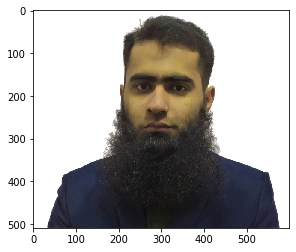

In [59]:
#for show image
show = ['usman1.jpg','shoaib2.jpg']
#find distance
print(np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))
#plot image according to results
plt.imshow( io.imread(show[np.argmin( np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))]))

### Testing 2

In [134]:
# Images for testing
test_image= [('shoaib2.jpg','shoaib3.jpg','usman2.jpg')]

In [135]:
# preprocessing and sent to dataset
test_dataset = FaceDataset(data_tuple = test_image, transform=transforms.Compose([
                                                                                Rescale(128),
                                                                                   ToTensor()]))

In [136]:
# sent detals into data loader
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [137]:
# for testing
for batch, (x, y , z) in enumerate(test_dataloader):
        print(x.shape,y.shape,z.shape)
        x, y , z = x.to(device), y.to(device), z.to(device)
        x = x.float()
        usman1 = model(x)
        # Compute prediction error
        y = y.float()
        usman2 = model(y)
        z = z.float()
        shoaib2 = model(z)
        print('done')

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
done


In [138]:
# dict contanin testing on it
dict_ = np.array([usman2.detach().numpy()[0] , shoaib2.detach().numpy()[0]])
test_ = usman1.detach().numpy()[0]

[47.700478 68.41827 ]


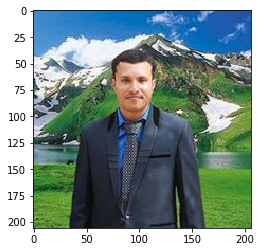

In [139]:
#for show image
show = ['shoaib3.jpg','usman2.jpg']
#find distance
print(np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))
#plot image according to results
plt.imshow( io.imread(show[np.argmin( np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))]))

### Testing 3

In [78]:
# Images for testing
test_image= [('H1.jpeg','H2.jpeg','shoaib1.jpg')]

In [79]:
# preprocessing and sent to dataset
test_dataset = FaceDataset(data_tuple = test_image, 
                                           transform=transforms.Compose([
                                               Rescale(128),
                                               ToTensor()]))

In [80]:
# sent detals into data loader
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [81]:
# for testing
for batch, (x, y , z) in enumerate(test_dataloader):
        print(x.shape,y.shape,z.shape)
        x, y , z = x.to(device), y.to(device), z.to(device)
        x = x.float()
        usman1 = model(x)
        # Compute prediction error
        y = y.float()
        usman2 = model(y)
        z = z.float()
        shoaib2 = model(z)
        print('done')

torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128]) torch.Size([1, 3, 128, 128])
done


In [82]:
# dict contanin testing on it
dict_ = np.array([usman2.detach().numpy()[0] , shoaib2.detach().numpy()[0]])
test_ = usman1.detach().numpy()[0]

[32.41579  63.646427]


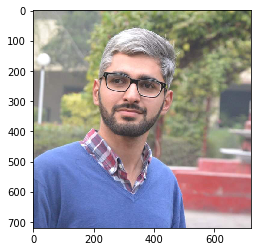

In [83]:
show = ['H2.jpeg','shoaib1.jpg']
#find distance
print(np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))
#plot image according to results
plt.imshow( io.imread(show[np.argmin( np.sqrt( np.sum( (dict_ - test_)**2 , axis = 1)))]))